In [1]:
#!/usr/bin/env python3

import gzip
import pickle
import argparse
import copy
import gc
import glob
import json
import os
import random
import sys
import time
import uuid
import warnings
from typing import Callable, Dict, List, Tuple, Any


import matplotlib.pyplot as plt
import copy

import numpy as np
import pandas as pd
import tqdm
from loguru import logger
from sklearn import pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

import shap

# import dotenv


# Way to dynamically change the number of jobs at run time
def get_num_jobs(default_jobs: int) -> int:
    """This function provides a way to override the number of jobs specified
    in the command line arguments dynamically.
    A file called num_jobs.txt can be created and the first line
    should contain the number of jobs.

    Args:
        default_jobs (int): default value if it is not overridden

    Returns:
        int: number of jobs to run
    """
    if not os.path.exists("num_jobs.txt"):
        return default_jobs
    with open("num_jobs.txt") as f:
        try:
            line = f.readlines()[0].strip()
            temp_jobs = int(line)
            if temp_jobs > 0 and temp_jobs < 20:
                logger.info(f"NUM_JOBS override: {temp_jobs}")
                return temp_jobs
        except:
            return default_jobs
    return default_jobs


def random_seed() -> None:
    np.random.seed(0)
    random.seed(0)


def get_save_filename() -> str:
    return f"{str(uuid.uuid4())}.csv.gz"


def gc_collect() -> None:
    for i in range(3):
        for j in range(3):
            gc.collect(j)


def get_columns_and_types(thisdf: pd.DataFrame) -> Dict[str, List[str]]:
    """For each feature set type, get the relevant columns.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        Dict[str, List[str]]: Dictionary that maps the feature type to the
            list of columns to the feature type.
    """
    columns = [c for c in thisdf.columns if not c.startswith("an_")]

    def get_columns(columns: List[str], start_string: str) -> List[str]:
        columns = [c for c in columns if c.startswith(start_string)]
        columns = [c for c in columns if "head" not in c and "tail" not in c]
        columns = [c for c in columns if "begin" not in c and "end" not in c]
        columns = [c for c in columns if "filesize" not in c]
        columns = [c for c in columns if "fourier.value" not in c.lower()]
        return columns

    baseline_columns = get_columns(columns, "baseline")
    advanced_columns = get_columns(columns, "advanced")
    fourier_columns = get_columns(columns, "fourier")
    fourier_min_columns = [
        "fourier.stat.1byte.autocorr",
        "fourier.stat.1byte.mean",
        "fourier.stat.1byte.std",
        "fourier.stat.1byte.chisq",
        "fourier.stat.1byte.moment.2",
        "fourier.stat.1byte.moment.3",
        "fourier.stat.1byte.moment.4",
        "fourier.stat.1byte.moment.5",
    ]

    baseline_and_advanced = list(set(baseline_columns + advanced_columns))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns))
    advanced_and_fourier = list(set(advanced_columns + fourier_columns))
    baseline_and_fourier_min = list(set(baseline_columns + fourier_min_columns))
    advanced_and_fourier_min = list(set(advanced_columns + fourier_min_columns))


    baseline_advanced_fourier = list(
        set(baseline_columns + advanced_columns + fourier_columns)
    )
    baseline_advanced_and_fourier_min = list(
        set(baseline_columns + advanced_columns + fourier_min_columns)
    )

    rv = {
        "baseline-advanced-and-fourier": baseline_advanced_fourier,
    }

    #logger.info(f"Features = {rv}")

    return rv


def get_annotation_columns(thisdf: pd.DataFrame) -> List[str]:
    """List of columns used for annotation.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        _type_: List of columns
    """
    return [c for c in thisdf.columns if c.startswith("an_")]


def annotate_df_with_additional_fields(
    name: str, dataframe: pd.DataFrame
) -> pd.DataFrame:
    """Add some metadata to each dataframe

    Args:
        name (str): Name of the csv/parquet file
        dataframe (pd.DataFrame): Dataframe

    Returns:
        pd.DataFrame: Dataframe with additional information
    """
    if "base32" in name or "b32" in name:
        dataframe["an_is_base32"] = 1
    else:
        dataframe["an_is_base32"] = 0
    dataframe["an_is_base32"] = dataframe["an_is_base32"].astype(np.bool_)

    if "encrypt" in name:
        dataframe["is_encrypted"] = 1
    else:
        dataframe["is_encrypted"] = 0
    dataframe["is_encrypted"] = dataframe["is_encrypted"].astype(np.bool_)

    if "v1" in name:
        dataframe["an_v1_encrypted"] = 1
    else:
        dataframe["an_v1_encrypted"] = 0
    dataframe["an_v1_encrypted"] = dataframe["an_v1_encrypted"].astype(np.bool_)

    if "v2" in name:
        dataframe["an_v2_encrypted"] = 1
    else:
        dataframe["an_v2_encrypted"] = 0
    dataframe["an_v2_encrypted"] = dataframe["an_v2_encrypted"].astype(np.bool_)

    if "v3" in name:
        dataframe["an_v3_encrypted"] = 1
    else:
        dataframe["an_v3_encrypted"] = 0
    dataframe["an_v3_encrypted"] = dataframe["an_v3_encrypted"].astype(np.bool_)

    def is_webp(filename: str) -> int:
        return 1 if ".webp" in filename else 0

    dataframe["an_is_webp"] = (
        dataframe["extended.base_filename"].map(is_webp).astype(np.bool_)
    )

    return dataframe


def load_data(input_directory: str) -> pd.DataFrame:
    """Load all pandas data files from a directory and annotate them with
    additional fields

    Args:
        input_directory (str): input directory

    Returns:
        pd.DataFrame: A combined dataframe of all files (Train)
        pd.DataFrame: A combined dataframe of all files (Test)
    """

    interesting_files = [
        "plaintext.base32.combined.csv.gz",
        "expanded.base32.des3.csv.gz",
        "n1.plaintext.base32.csv.gz",
        "expanded_encrypted_v3.csv.gz",
        "n1.expanded.plaintext.csv.gz",
        "n1.expanded.pyencrypted_v2.csv.gz",
        "n1.expanded.pyencrypted_v1.base32.csv.gz",
        "expanded.des3.csv.gz",
        "n1.expanded.pyencrypted_v2.base32.csv.gz",
        "expanded.pyencrypted_v1.csv.gz",
        "expanded.pyencrypted_v2.base32.csv.gz",
        "expanded_encrypted_v3_base32.csv.gz",
        "n1.expanded.pyencrypted_v3.base32.csv.gz",
        "plaintext.combined.csv.gz",
        "plaintext.expanded.csv.gz",
        "expanded.pyencrypted_v2.csv.gz",
        "expanded.plaintext.base32.csv.gz",
        "n1.expanded.pyencrypted_v3.csv.gz",
        "n1.expanded.plaintext.base32.csv.gz",
        "n1.plaintext.csv.gz",
        "expanded.pyencrypted_v1.b32.csv.gz",
        "n1.expanded.pyencrypted_v1.csv.gz",
    ]
    p = 0.1
    logger.info("Loading dataframes")
    dataframes = {
        # f: pd.read_csv(f, skiprows=lambda i: i > 0 and random.random() > p)
        f: pd.read_csv(f)  # , nrows=50)
        for f in tqdm.tqdm(
            glob.glob(f"{input_directory}{os.path.sep}*.csv.gz"), desc="Loading data"
        )
        if os.path.basename(f).lower() in interesting_files and os.path.basename(f).lower().startswith("n1")
    }

    logger.info("Annotating dataframes with additional fields")
    dataframes = {
        f: annotate_df_with_additional_fields(f, df) for f, df in dataframes.items()
    }

    logger.info("Combining test dataframes into a single dataframe")
    test_df = (
        pd.concat([df for fname, df in dataframes.items() if "n1." in fname.lower()])
        .sample(frac=1)
        .reset_index(drop=True)
    )


    gc_collect()

    logger.info("done...")
    return test_df


# def get_pipeline(
#     X: pd.DataFrame, n_jobs: int = 4
# ) -> Tuple[pipeline.Pipeline, Callable[[np.array], np.array]]:
#     random_seed()
#     num_jobs = get_num_jobs(n_jobs)
#     pipe = pipeline.Pipeline(
#         [
#             ("std", MinMaxScaler()),
#             ("classif", RandomForestClassifier(n_jobs=num_jobs)),
#         ]
#     )
#     # In case the predicted value needs to be converted to an integer
#     # this lambda will do the work
#     return pipe, lambda x: x


def get_pipeline(
    X: pd.DataFrame, n_jobs: int = 4
) -> Tuple[pipeline.Pipeline, Callable[[np.array], np.array]]:
    random_seed()
    num_jobs = get_num_jobs(n_jobs)
    with open("/Users/phantom/dev/paperv2/E2/rf_model-no-fourier-values.pkl", "rb") as f:
        pipe = pickle.load(f)
    # In case the predicted value needs to be converted to an integer
    # this lambda will do the work
    return pipe, lambda x: x




def get_metrics(y_true: np.array, y_pred: np.array) -> List[float]:
    def error_checked_metric(fn, y_true, y_pred):
        try:
            return fn(y_true, y_pred)
        except Exception as e:
            return 1.0  # Treat as fully accurate

    return [
        error_checked_metric(fn, y_true, y_pred)
        for fn in [
            accuracy_score,
            balanced_accuracy_score,
            f1_score,
            precision_score,
            recall_score,
            roc_auc_score,
        ]
    ]


def evaluate(
    name: str,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    output_directory: str,
    feature_column_names: List[str],
    annotation_columns: List[str],
    n_jobs: int,
) -> None:
    random_seed()
    colnames = [c for c in feature_column_names if "is_encrypted" not in c]
    colnames = [c for c in colnames if c not in annotation_columns]
    colnames = [c for c in colnames if not c.startswith("an_")]
    colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
    X_train = train_df[colnames].to_numpy()
    y_train = train_df["is_encrypted"].to_numpy().flatten()
    X_test = test_df[colnames].to_numpy()
    y_test = test_df["is_encrypted"].to_numpy().flatten()

    # train_filenames = train_df["extended.base_filename"].flatten()
    test_filenames = test_df["extended.base_filename"].to_numpy().flatten()

    # pline, y_pred_fn = get_pipeline(X, n_jobs=n_jobs)
    pline, y_pred_fn = get_pipeline(X_train, n_jobs=n_jobs)
    pline.fit(X_train, y_train)
    y_pred = pline.predict(X_test).flatten()
    y_predict_proba = pline.predict_proba(X_test)[:, 1].flatten()

    with open("rf_model.pkl", "wb") as f:
        pickle.dump(pline, f, pickle.HIGHEST_PROTOCOL)

    save_filename = output_directory + os.path.sep + name + ".csv.gz"
    df2 = pd.DataFrame(
        {
            "filename": test_filenames,
            "y_true": y_test,
            "y_pred": y_pred,
            "y_pred_proba": y_predict_proba,
        }
    )
    logger.info(f"Saving to {save_filename}")
    df2.to_csv(save_filename)
    return df2


def main() -> None:
    # dotenv.load_dotenv()
    warnings.filterwarnings("ignore")
    parser = argparse.ArgumentParser("Run experiments")
    parser.add_argument(
        "-i",
        "--input-directory",
        type=str,
        required=True,
        help="Input directory for data files.",
    )
    parser.add_argument(
        "-o",
        "--output-directory",
        type=str,
        required=True,
        help="Output directory.",
    )
    parser.add_argument(
        "-nj", "--n-jobs", type=int, default=4, help="Number of jobs to run."
    )
    args = parser.parse_args()

    if not os.path.exists(args.input_directory) or not os.path.isdir(
        args.input_directory
    ):
        raise Exception(f"Path {args.input_directory} does not exist")
    if not os.path.exists(args.output_directory) or not os.path.isdir(
        args.output_directory
    ):
        os.mkdir(args.output_directory)

    log_file = f"{args.output_directory}{os.path.sep}log.log"
    if os.path.exists(log_file):
        os.unlink(log_file)
    if os.path.exists(f"{log_file}.debug.log"):
        os.unlink(f"{log_file}.debug.log")
    logger.remove()
    logger.add(log_file, backtrace=True, diagnose=True, level="INFO")
    logger.add(f"{log_file}.debug.log", backtrace=True, diagnose=True, level="DEBUG")
    logger.add(sys.stderr, backtrace=True, diagnose=True, level="ERROR")
    logger.opt(colors=True).info(f"<blue>Running with {args}</>")

    random_seed()

    master_train_df, master_test_df = load_data(args.input_directory)

    annot_columns = get_annotation_columns(master_train_df)

    dataframes_list = []
    for n, (fsname, fscolumns) in enumerate(
        tqdm.tqdm(
            get_columns_and_types(master_train_df).items(),
            desc="Iterating through feature sets",
            colour="blue",
        )
    ):
        temp_output_dir = f"{args.output_directory}"  # + os.path.sep + f"{fsname}"

        print_text = f"******** Processing {fsname} and writing into {temp_output_dir}"
        logger.opt(colors=True).info(f"<green>{print_text}</>")
        logger.opt(colors=True).info(f"<green>{'-' * len(print_text)}</>")

        columns = copy.copy(fscolumns)
        columns += annot_columns
        columns += ["is_encrypted", "extended.base_filename"]

        if not os.path.exists(temp_output_dir):
            os.mkdir(temp_output_dir)
        t1 = time.perf_counter()

        logger.info(f"**** {n:02d}. Started evaluating feature set: {fsname}")
        logid = logger.add(
            temp_output_dir + os.path.sep + "log.log",
            backtrace=True,
            diagnose=True,
            level="INFO",
        )

        # print(fscolumns)
        df = evaluate(
            name=fsname,
            train_df=master_train_df[columns].copy(),
            test_df=master_test_df[columns].copy(),
            output_directory=temp_output_dir,
            feature_column_names=fscolumns,
            annotation_columns=annot_columns,
            n_jobs=args.n_jobs,
        )
        logger.remove(logid)

        t2 = time.perf_counter()
        logger.info(f"{n:02d}. Completed running feature {fsname} in {t2 - t1} seconds")

        df["feature_set"] = fsname
        dataframes_list.append(df)
    print("Finished... OK")
    logger.opt(colors=True).info(f"<green>Finished... OK</>")

    df = pd.concat(dataframes_list)
    df.to_csv(f"{args.output_directory}{os.path.sep}combined.csv.gz")



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data_directory = "/Users/phantom/dev/NapierOne"
master_df = load_data(data_directory)
pline, _ = get_pipeline(None, None)
# explainer = shap.TreeExplainer(pline.named_steps['classif'])

2023-07-16 10:55:54.601 | INFO     | __main__:load_data:241 - Loading dataframes
Loading data: 100%|█████████████████████████████████████████████████████████████████████████████| 53/53 [00:23<00:00,  2.29it/s]
2023-07-16 10:56:17.736 | INFO     | __main__:load_data:251 - Annotating dataframes with additional fields
2023-07-16 10:56:17.803 | INFO     | __main__:load_data:256 - Combining test dataframes into a single dataframe
2023-07-16 10:56:20.522 | INFO     | __main__:load_data:266 - done...


In [3]:
columns = get_columns_and_types(master_df)['baseline-advanced-and-fourier']
shuffled_df = master_df.sample(frac=1).reset_index(drop=True)

temp_df = master_df.sample(frac=1).reset_index(drop=True)
temp_df = temp_df.head(2)
X = temp_df[columns]

print(f"{X.shape=}")
y = temp_df["is_encrypted"].to_numpy().flatten()


# shap_values = []
# for i in tqdm.tqdm(range(X.shape[0])):
#     shap_value = explainer.shap_values(X.iloc[[i]], check_additivity=False)
#     shap_values.append(shap_value)

X.shape=(2, 81)


In [4]:

# def get_shap_values(pipeline: Any, df: pd.DataFrame) -> List[Any]:
#     columns = get_columns_and_types(df)['baseline-advanced-and-fourier']
#     X = df[columns]
#     explainer = shap.TreeExplainer(pipeline.named_steps['classif'], check_additivity=False)
    
#     shap_values1 = explainer(X.to_numpy(), check_additivity=False)
#     shap_values2 = copy.deepcopy(shap_values1)
#     shap_values2.values = shap_values2.values[:,:,1]
#     shap_values2.base_values = shap_values2.base_values[:,-1]
    
# #     shap_values = []  
# #     for i in tqdm.tqdm(range(X.shape[0])):
# #         shap_value = explainer.shap_values(X.iloc[[i]], check_additivity=False)
# #         shap_values.append(shap_value)
# #     return shap_values
    
#     return explainer.shap_values(X, check_additivity=False), shap_values1, shap_values2



# pass

# # import shap
# # import copy
# # from sklearn.datasets import load_breast_cancer

# # X,y = load_breast_cancer(return_X_y=True)
# # lgbm = RandomForestClassifier()
# # lgbm.fit(X,y)


# # explainer = shap.TreeExplainer(lgbm)
# # shap_values1 = explainer(X)
# # shap_values2 = copy.deepcopy(shap_values1)
# # shap_values2.values = shap_values2.values[:,:,1]
# # shap_values2.base_values = shap_values2.base_values[:,1]

# # shap.plots.beeswarm(shap_values2)

In [5]:

# def shap_summary_plot(shap_values_array: List[Any], X: pd.DataFrame, n: int) -> Any:
#     shap_values = np.vstack(shap_values)
#     feature_importance = np.abs(shap_values).mean(0)
#     top_n_indices = np.argsort(feature_importance)[-n:]
    
#     top_n_shap_values = shap_values[:, top_n_indices]
#     top_n_features = X.iloc[:, top_n_indices]
    
#     shap.summary_plot(top_n_shap_values, top_n_features)
    
# shap_values, shap_values1, shap_values2 = get_shap_values(pline, X)
# # shap_summary_plot(shap_values, X, 100)
# shap.plots.beeswarm(shap_values2)

In [6]:
# shpval = [np.vstack(i) for i in shap_values]
# importances = np.abs(shpval).mean(0)

# top_20_indices = np.argsort(importances)[-20:]

In [7]:
# np.argsort(importances).shape

In [8]:
# shap.summary_plot(importances[:, top_20_indices], X[:, top_20_indices])

In [9]:
# import shap
# import copy
# from sklearn.datasets import load_breast_cancer

# X,y = load_breast_cancer(return_X_y=True)
# lgbm = RandomForestClassifier()
# lgbm.fit(X,y)


# explainer = shap.TreeExplainer(lgbm)
# shap_values1 = explainer(X)
# shap_values2 = copy.deepcopy(shap_values1)
# shap_values2.values = shap_values2.values[:,:,1]
# shap_values2.base_values = shap_values2.base_values[:,1]

# shap.plots.beeswarm(shap_values2)

Inner Time elapsed: 45.19839020400104


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


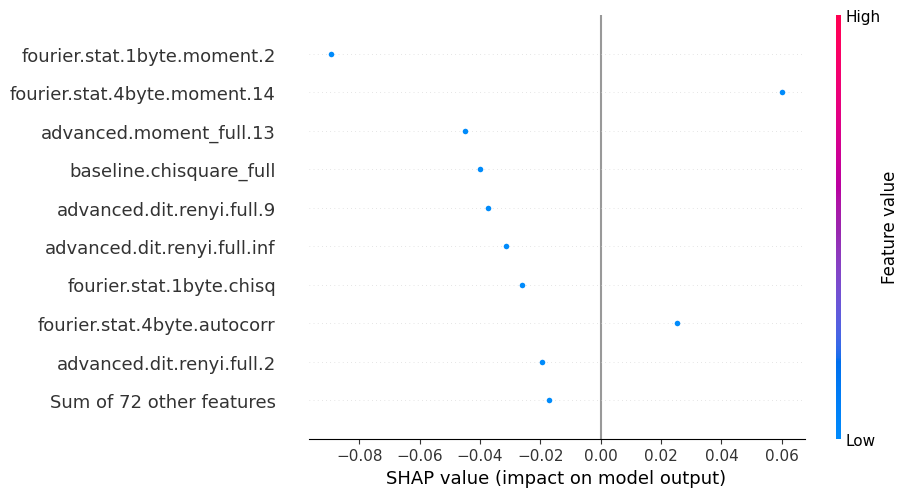

Time elapsed: 48.84618160499667


In [10]:
# See https://github.com/slundberg/shap/issues/2703


def shapley_plot(pipe, X: pd.DataFrame):
    X = X.copy()
    annotation_columns = [c for c in X.columns if c.startswith("an_")]
    colnames = [c for c in X.columns if "is_encrypted" not in c]
    colnames = [c for c in colnames if c not in annotation_columns]
    colnames = [c for c in colnames if not c.startswith("an_")]
    colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
    X = X[colnames]
    
    explainer = shap.TreeExplainer(pipe.named_steps['classif'], seed=42)
    
    t1 = time.perf_counter()
    explanation = explainer(
        pipe.named_steps['std'].transform(X.to_numpy()),
        check_additivity=False)
    t2 = time.perf_counter()
    print(f"Inner Time elapsed: {t2 - t1}")
    feature_names = X.columns
    
    explanation2 = shap.Explanation(
        values=explanation.values, 
        base_values=explanation.base_values, 
        data=explanation.data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(explanation2[:, :, 1])
    
    return explainer, explanation, explanation2
    

    
    
columns = get_columns_and_types(master_df)['baseline-advanced-and-fourier']

temp_df = master_df.sample(frac=1).reset_index(drop=True)
temp_df = temp_df.head(1)
X = temp_df[columns]

import time
t1 = time.perf_counter()
explainer_30, explanation_30, explanation2_30 = shapley_plot(pline, X)
t2 = time.perf_counter()
print(f"Time elapsed: {t2 - t1}")




No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


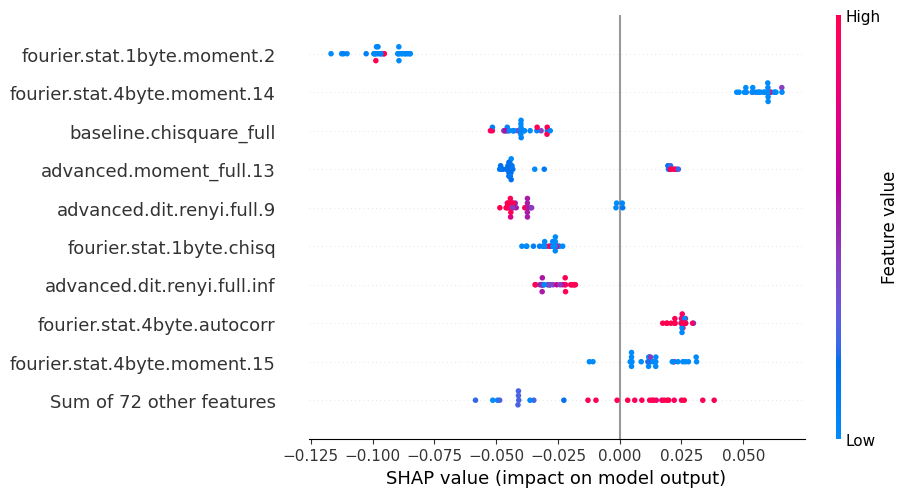

In [11]:
# See https://github.com/slundberg/shap/issues/2703


def shapley_plot(pipe, X: pd.DataFrame):
    X = X.copy()
    annotation_columns = [c for c in X.columns if c.startswith("an_")]
    colnames = [c for c in X.columns if "is_encrypted" not in c]
    colnames = [c for c in colnames if c not in annotation_columns]
    colnames = [c for c in colnames if not c.startswith("an_")]
    colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
    X = X[colnames]
    
    explainer = shap.TreeExplainer(pipe.named_steps['classif'], seed=42)
    explanation = explainer(
        pipe.named_steps['std'].transform(X.to_numpy()),
        check_additivity=False)
    feature_names = X.columns
    
    explanation2 = shap.Explanation(
        values=explanation.values, 
        base_values=explanation.base_values, 
        data=explanation.data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(explanation2[:, :, 1])
    
    return explainer, explanation, explanation2
    

    
    
columns = get_columns_and_types(master_df)['baseline-advanced-and-fourier']

temp_df = master_df.sample(frac=1).reset_index(drop=True)
temp_df = temp_df.head(30)
X = temp_df[columns]
explainer_30, explanation_30, explanation2_30 = shapley_plot(pline, X)

pickle_dict = {
    "explainer_30": explainer_30,
    "explanation_30": explanation_30,
    "explanation2_30": explanation2_30
}

with open("shap-no-fourier-values_30.pkl", "wb") as f:
    pickle.dump(pickle_dict, f, pickle.HIGHEST_PROTOCOL)
    
try:
    plt.show()
except:
    pass

In [12]:
# master_columns = set([str(c) for c in master_df])

# X = X.copy()
# annotation_columns = [c for c in X.columns if c.startswith("an_")]
# colnames = [c for c in X.columns if "is_encrypted" not in c]
# colnames = [c for c in colnames if c not in annotation_columns]
# colnames = [c for c in colnames if not c.startswith("an_")]
# colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
# X = X[colnames]

# x_columns = set(str(c) for c in X.columns)

# print(f"{master_columns - x_columns}")

# Now run for 500 samples for all the files together

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


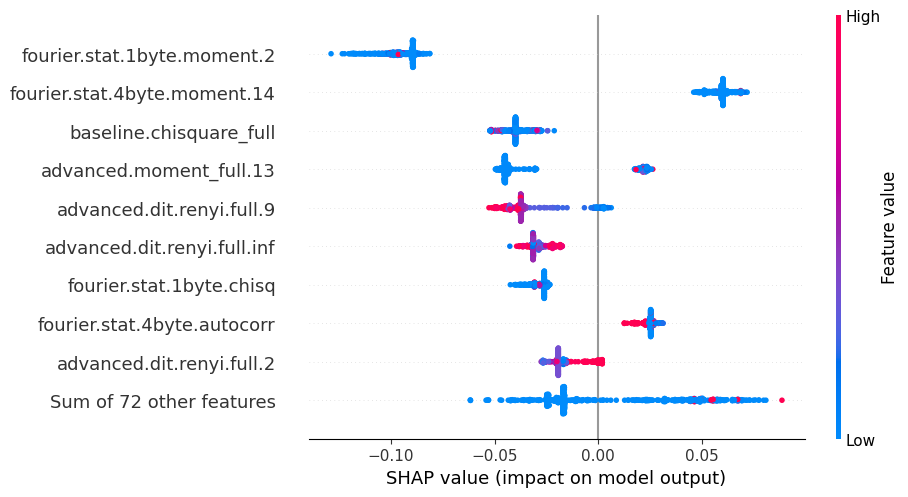

In [13]:
def shapley_plot(pipe, X: pd.DataFrame):
    X = X.copy()
    annotation_columns = [c for c in X.columns if c.startswith("an_")]
    colnames = [c for c in X.columns if "is_encrypted" not in c]
    colnames = [c for c in colnames if c not in annotation_columns]
    colnames = [c for c in colnames if not c.startswith("an_")]
    colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
    X = X[colnames]
    
    explainer = shap.TreeExplainer(pipe.named_steps['classif'], seed=42)
    explanation = explainer(
        pipe.named_steps['std'].transform(X.to_numpy()),
        check_additivity=False)
    feature_names = X.columns
    
    explanation2 = shap.Explanation(
        values=explanation.values, 
        base_values=explanation.base_values, 
        data=explanation.data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(explanation2[:, :, 1])
    
    return explainer, explanation, explanation2






columns = get_columns_and_types(master_df)['baseline-advanced-and-fourier']

temp_df = master_df.sample(frac=1).reset_index(drop=True)
temp_df = temp_df.head(500)
X = temp_df[columns]
explainer_500, explanation_500, explanation2_500 = shapley_plot(pline, X)


pickle_dict = {
    "explainer_500": explainer_500,
    "explanation_500": explanation_500,
    "explanation2_500": explanation2_500
}

with open("shap_no_fourier_values_500.pkl", "wb") as f:
    pickle.dump(pickle_dict, f, pickle.HIGHEST_PROTOCOL)
    
try:
    plt.show()
except:
    pass

# 1000

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


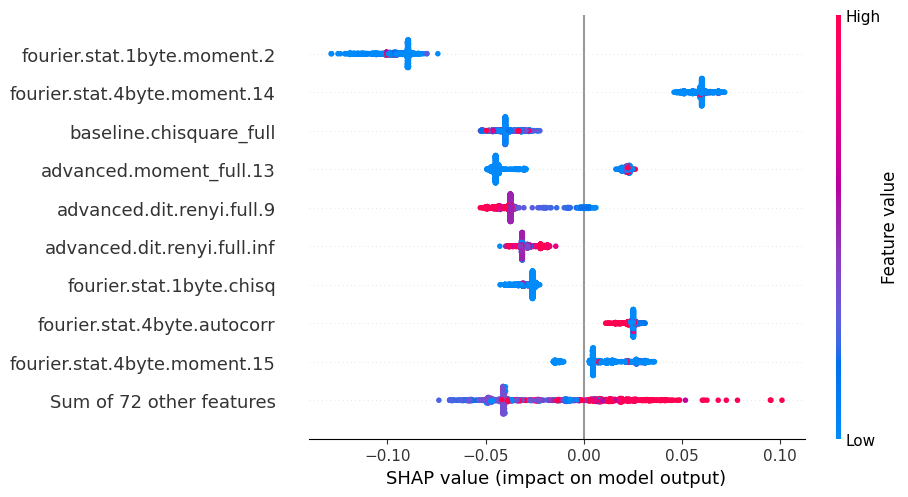

In [14]:
def shapley_plot(pipe, X: pd.DataFrame):
    X = X.copy()
    annotation_columns = [c for c in X.columns if c.startswith("an_")]
    colnames = [c for c in X.columns if "is_encrypted" not in c]
    colnames = [c for c in colnames if c not in annotation_columns]
    colnames = [c for c in colnames if not c.startswith("an_")]
    colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
    X = X[colnames]
    
    explainer = shap.TreeExplainer(pipe.named_steps['classif'], seed=42)
    explanation = explainer(
        pipe.named_steps['std'].transform(X.to_numpy()),
        check_additivity=False)
    feature_names = X.columns
    
    explanation2 = shap.Explanation(
        values=explanation.values, 
        base_values=explanation.base_values, 
        data=explanation.data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(explanation2[:, :, 1])
    
    return explainer, explanation, explanation2






columns = get_columns_and_types(master_df)['baseline-advanced-and-fourier']

temp_df = master_df.sample(frac=1).reset_index(drop=True)
temp_df = temp_df.head(1000)
X = temp_df[columns]
explainer_1000, explanation_1000, explanation2_1000 = shapley_plot(pline, X)


pickle_dict = {
    "explainer_1000": explainer_1000,
    "explanation_1000": explanation_1000,
    "explanation2_1000": explanation2_1000
}

with open("shap_no_fourier_values_1000.pkl", "wb") as f:
    pickle.dump(pickle_dict, f, pickle.HIGHEST_PROTOCOL)
    
try:
    plt.show()
except:
    pass

In [15]:
master_df.shape

(88810, 682)